In [1]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '1000'
environ['batch_norm']= 'True'
environ['loss_func']='MAPE'
environ['layers'] = '500 300 120 80 30'
environ['dropouts'] = '0.2'+' 0.3'*4
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:1'
environ['dataset'] = 'data/blur2d.pkl'

%run utils.ipynb

In [2]:
ds = DatasetFromPkl(dataset, maxsize=None, log=log)

dl = DataLoader(ds, batch_size=batch_size,
                        sampler=SubsetRandomSampler(range(len(ds))),
                         num_workers=num_workers)

db = fai.basic_data.DataBunch(dl, dl, device=device)

train_dl = dl

In [13]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion],
               callback_fns=[partial(EarlyStoppingCallback, mode='min', 
                                        monitor='mape_criterion', min_delta=0.1, patience=500)])

if optimizer == 'SGD':
    l.opt_func = optim.SGD 
    

In [14]:
lr = 1e-03

In [15]:
l.fit_one_cycle(50, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,81.774200,99.998917,99.998917,1.069233
2,80.609177,99.998917,99.998917,1.069233
3,84.338165,99.998917,99.998917,1.069233
4,84.551628,99.998917,99.998917,1.069233
5,84.502579,99.998917,99.998917,1.069233
6,84.959251,99.998917,99.998917,1.069233
7,84.514809,99.998917,99.998917,1.069233
8,84.885635,99.998940,99.998940,1.069233
9,84.326820,99.998917,99.998917,1.069233
10,84.278908,99.998917,99.998917,1.069233


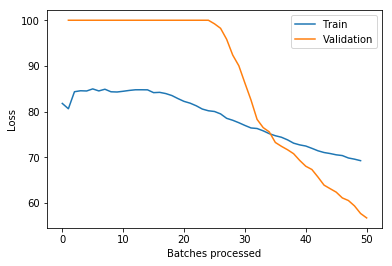

In [16]:
l.recorder.plot_losses()

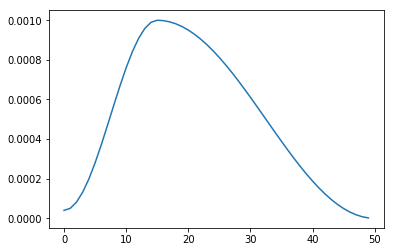

In [17]:
l.recorder.plot_lr()

In [19]:
l = l.load(f"training_tuning")

In [22]:

train_df = get_results_df(train_dl, l.model)
df = train_df

In [28]:
df.head()

,index,name,sched_name,prediction,target,abs_diff,APE,SMAPE,interchange,tile,unroll
0,0,function1024,function1024_no_schedule,0.928750,1.000000,0.071250,7.124996,7.388201,0,0,0
1,1,function1024,function1024_schedule_11,0.706367,1.305714,0.599347,45.901878,59.574875,0,1,0
2,2,function1024,function1024_schedule_15,0.666024,1.197540,0.531516,44.383999,57.042976,0,1,0
3,3,function1024,function1024_schedule_18,0.665433,1.637509,0.972076,59.363113,84.420403,0,1,1
4,4,function1024,function1024_schedule_19,0.648244,1.183270,0.535026,45.215916,58.424503,0,1,0


In [53]:
ds.schedules[3].schedule_list

[{'type': 'interchange', 'params': [-1, -1], 'factors': None},
 {'type': 'tiling', 'params': [100, 101], 'factors': [64, 32]},
 {'type': 'unrolling', 'params': None, 'factors': [16]}]

,achieved_speedup,max_speedup,performance,ranking,schedules_count
0,1.29469,1.731218,0.747849,5,26
